# New Features 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as ks

#unsupervised:
from sklearn.cluster import KMeans
#transformers:
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


#Note: train data has 13 feature column and 1 binary label for a total of 14 columns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(9)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
xx = train.drop(columns = 'Exited', axis = 0).copy() 
y = train.Exited.copy()

In [6]:
# Below is the transformer to add feature columns prior to individual columns transformation
# Involvement increased 
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.standardScaler = StandardScaler()
    def fit(self, X, y=None):
        X['BalanceCoverage'] = X.EstimatedSalary / (X.Balance +1)
        X['HasCrCardAndBalance'] = X.apply(lambda z: self.checkHasCrAndBalance(z.Balance, z.HasCrCard), axis = 1)
        X['HasBalance'] = X.Balance.apply(lambda z: 0 if( z < 1) else 1)
        X['IsSenior'] = X.Age.apply(lambda z: 0 if(z <60) else 1)
        X['Involvement'] = X.HasCrCard + X.IsActiveMember + X.NumOfProducts + X.HasBalance
        a = np.array(X[['BalanceCoverage','HasCrCardAndBalance','HasBalance', 'IsSenior', 'Involvement']])
        self.standardScaler.fit(a)
        return self

    def checkHasCrAndBalance(self, a,b):
        flag = 0
        if((a > 0) and (b > 0)):
            flag = 1
        return flag

    def transform(self, X):
        X['BalanceCoverage'] = X.EstimatedSalary / (X.Balance +1)
        X['HasCrCardAndBalance'] = X.apply(lambda z: self.checkHasCrAndBalance(z.Balance, z.HasCrCard), axis = 1)
        X['HasBalance'] = X.Balance.apply(lambda z: 0 if( z < 1) else 1)
        X['IsSenior'] = X.Age.apply(lambda z: 0 if(z <60) else 1)
        X['Involvement'] = X.HasCrCard + X.IsActiveMember + X.NumOfProducts + X.HasBalance 
        a = np.array(X[['BalanceCoverage','HasCrCardAndBalance','HasBalance', 'IsSenior', 'Involvement']])
        #return self.standardScaler.transform(a) 
        return X.copy()
        
        
        

In [7]:
a = FeatureCreation().fit_transform(train)

In [8]:
a[:4]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceCoverage,HasCrCardAndBalance,HasBalance,IsSenior,Involvement
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,181449.970000,0,0,0,3.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,49503.500000,0,0,0,4.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,184866.690000,0,0,0,3.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.567967,1,1,0,4.0


In [9]:
a.NumOfProducts.unique()

array([2, 1, 3, 4])

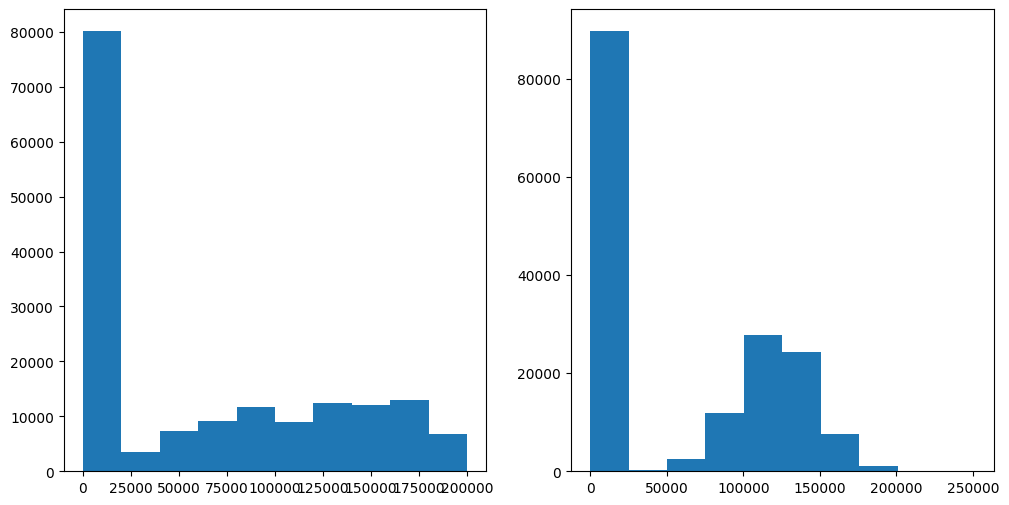

In [10]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))
ax[0].hist(a.BalanceCoverage)
ax[1].hist(a.Balance)
plt.show()

In [11]:
st.pearsonr(a.Balance, a.BalanceCoverage)

PearsonRResult(statistic=-0.801729864408831, pvalue=0.0)

In [12]:
tt = TargetEncoder()
tt.fit_transform(np.array(train['Surname']).reshape(-1,1), y)

array([[0.32325549],
       [0.32846132],
       [0.22389677],
       ...,
       [0.21205904],
       [0.24006242],
       [0.22807391]])

In [13]:
X.Surname.shape

NameError: name 'X' is not defined

In [ ]:
X.Surname.unique().shape

In [ ]:
X.shape

In [ ]:
a = train.loc[train.Surname == train.Surname.unique()[1000],]
print("shape: {}".format(a.shape))
tot_exited = a.Exited.sum()
print("n_exited: {}".format(a.Exited.sum()))
print("ratio_of_exited: {}".format(tot_exited/a.shape[0]))

In [ ]:
a.head(5)

In [ ]:
a = pd.crosstab(index = [train.Geography], columns = train.Exited).tail(10)
a

In [ ]:
train.shape

In [ ]:
train.Surname.unique().shape

In [ ]:
equals = []
for i in train.CustomerId.unique():
    for j in test.CustomerId.unique():
        if(i == j):
            equals.append(i)


In [ ]:
len(equals)

In [ ]:
test.shape

In [ ]:
tx_equal = train.loc[train.CustomerId == equals[0]]
tx_equal